#А/В-тест на обновление списка рекламы от партнеров#

**Описание**

Имеется набор данных, который мы получили в результате проведенного АВ-эксперимента. Данные были получены из теста, проведенного на платформе Marketpele Feed, которая помогает издательствам зарабатывать на рекламе. Список объявлений Marketpele содержит "органические" и "платные" элементы. Платные элементы - это рекламные объявления, при нажатии на них пользователи переходят на страницу рекламодателя и приносят доход Marketpele. Органические элементы - это контент издателя, при нажатии на них пользователи переходят на другую статью от того же издателя.  
В упомянутом выше тесте у группы A была лента, составленная из "органического" элемента наверху списка, и с четырьмя "платными" элементами внизу списка.  
У группы B была лента с четырьмя "платными" элементами наверху списка, за ними следовал один "органический" элемент.

In [1]:
import pandas as pd
import numpy as np
from math import *
from scipy.stats import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('ab_test.xlsx')
print(df.shape, df.columns)

(126, 10) Index(['date', 'publisher_id', 'platform', 'group_name', 'pageviews',
       'visible_pageviews', 'sessions', 'revenue', 'sponsord_clicks',
       'organic_clicks'],
      dtype='object')


Уникальный ключ состоит из: date, platform, publisher_id и group name.

Platform - платформа, на которой отображена страница (мобильная, десктопная);

Group name - группа A/B (органический элемент первый/органический последний);

Page views - количество веб-страниц, на которых был запущен тест;

Visible page views - количество просмотров страниц, где пользователь увидел ленту;

Sessions - все просмотры страниц пользователя на конкретном издателе в течение двух часов;

Sponsord clicks - клики по платным элементам (реклама);

Organic clicks - клики по элементам с контентом издателя.

##1. Определение цели##

Как и для любого бизнеса, наша основная цель - это ***увеличение прибыли***, добиться которой мы можем засчет дополнительных доходов от рекламы, размещенной на сайте.

Поэтому важно проверить следующие метрики:  

*RPM (Revenue per mille):* доход на 1 000 просмотров страниц

*RPS (Revenue per session):* доход на 1 000 сессий

*Paid/Organic CTR (Click-Through Rate):* коэффициент переходов (CTR) по платным/органическим кликам относительно числа просмотров страниц.

##2. Формулирование и приоритезация гипотез##

Сформируем гипотезы относительно нашего продукта, подсчитаем приоритеты для гипотез, выберем 2 гипотезы на проверку.

**Гипотеза №1:** Добавление всплывающего рекламного баннера с предложением о бесплатном доступе к набору книг при оформлении подписки на рекламную рассылку увеличит доходы от рекламы на 10%.

**Гипотеза №2:** Добавление рекомендаций на странице товара на основе предпочтений пользователей повысит конверсию в покупки на 20% среди клиентов, которые просматривают более 3 продуктов.

**Гипотеза №3:** Изменение цвета кнопки 'Подробнее' с синего на красный увеличит среднюю продолжительность сессий на сайте на 5%.

**Гипотеза №4:** Изменение расположения рекламных элементов на странице позволит увеличить коэффициент переходов (CTR) по платным кликам на 5%.

**Гипотеза №5:** Изменение расположения рекламных элементов на странице повысит метрики RPM и RPS на 5%.  

**Гипотеза №6:** Добавление текущих читательских трендов на страницу поднимет среднюю продолжительность сессий на сайте на 10%.

**Гипотеза №7:** Добавление возможности оплаты в рассрочку увеличит продажи среди аудитории 18-25 лет на 20%.  


Приоритизируем гипотезы методом **RICE**:  

R — Reach Охват (Охват оценивает, сколько пользователей затронет данная гипотеза)

I — Impact Влияние (Влияние оценивает степень влияния гипотезы на ключевые метрики или бизнес-показатели)

E — Efforts Усилия (Усилие оценивает общий объем усилий, требуемых для реализации гипотезы. Это включает в себя затраты времени, ресурсов, сложность разработки и другие параметры, связанные с внедрением изменений)

C — Confidence Уверенность (Уверенность оценивает степень уверенности команды в правильности оценок охвата, влияния и усилий. Это может включать уровень доказательства, данных, экспертного мнения и общей уверенности в том, что гипотеза будет успешной)

`RICE = (Reach * Impact * Confidence) / Efforts`

Будем оценивать каждый параметр по линейной шкале от 1 до 10.
Выведем рассчитанные баллы в виде таблицы.

In [3]:
d = {
    'Hypothesis': ['№1', '№2', '№3', '№4', '№5', '№6', '№7'],
    'Reach': [10, 1, 10, 10, 10, 10, 3],
    'Impact': [2.5, 2, 1.5, 3, 3, 1, 2],
    'Effort': [2, 5, 1, 1.5, 1.5, 2, 3],
    'Confidence': [3, 2, 2, 3, 3, 2, 3]
}
rice = pd.DataFrame(d)
rice['RICE score'] = (rice['Reach']*rice['Impact']*rice['Confidence'])/rice['Effort']
display(rice)

,Hypothesis,Reach,Impact,Effort,Confidence,RICE score
0,№1,10,2.5,2.0,3,37.5
1,№2,1,2.0,5.0,2,0.8
2,№3,10,1.5,1.0,2,30.0
3,№4,10,3.0,1.5,3,60.0
4,№5,10,3.0,1.5,3,60.0
5,№6,10,1.0,2.0,2,10.0
6,№7,3,2.0,3.0,3,6.0


Для проверки выбираем гипотезы №4 и №5.

##3. Дизайн A/B-теста##

**Цель тестирования** - зафиксировать положительное изменение в метриках:   
RPM (доход на 1 000 просмотров страниц),   
RPS (доход на 1 000 сессий),   
Paid/Organic CTR (коэффициент переходов (CTR) по платным/органическим кликам относительно числа просмотров страниц).

Определим нулевую и альтернативную гипотезы, для гипотез отобранных на проверку:  

**Продуктовая гипотеза 1**

Н0: После изменения расположения рекламных элементов на странице, среднее количество кликов по ним (CTR) не изменится, μ1 = μ2.

Н1: Среднее количество кликов на рекламные элементы (CTR) увеличится, μ2 > μ1.

**Продуктовая гипотеза 2**

Н0: После изменения расположения рекламных элементов на странице, метрики RPS и RPM не изменятся, μ1 = μ2.

Н1: Метрики RPS и RPM увеличатся, μ2 > μ2.

**Определение объема выборки и длительности теста**

Базовый paid CTR = 2%, мы хотим увидеть различия в 5% в метрике конверсия в клик по платному объявлению. Онлайн-калькулятор Evan Miller на основе данных параметров выдает размер выборки в 310000 наблюдений, но, так как это для
одной выборки, то нам необходимо **620000** наблюдений.

Трафик в день составляет 100 000 наблюдений. Так как у нас в эксперименте участвуют 2 платформы: Мобайл и десктоп, то считаем длительность по наименьшему количеству пользователей. На платформу десктоп в день приходят около 50 000 пользователей (по количеству сессий) в каждую группу, поэтому наш ожидаемый объем трафика в день равен 100 000. На основе имеющихся параметров калькулятор VWO рассчитал длительность теста равной **7 дням**.

Количество наблюдений в день из загруженного датасета:

In [4]:
sess_df = df.groupby(['date','group_name'])['sessions'].sum().reset_index()
sess_df

,date,group_name,sessions
0,2019-03-01,A,140626
1,2019-03-01,B,140176
2,2019-03-02,A,139401
3,2019-03-02,B,139335
4,2019-03-03,A,142512
5,2019-03-03,B,140728
6,2019-03-04,A,167851
7,2019-03-04,B,166922
8,2019-03-05,A,59250
9,2019-03-05,B,144124


##4. Проведение A/B-теста##

Так как в рамках данного проекта у нас уже имеется загруженный датасет с результатами A/B-теста, то в этом разделе отметим требования качественного разделения аудитории на группы:
- у каждого пользователя в течение эксперимента группа не должна меняться;
- количество пользователей в группах различается не более, чем на 1%;
- для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости.

##5. Подготовка данных##

Проведем исследование полученных в ходе эксперимента данных, для выявления основных характеристик, закономерностей и аномалий в них.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               126 non-null    datetime64[ns]
 1   publisher_id       126 non-null    int64         
 2   platform           126 non-null    object        
 3   group_name         126 non-null    object        
 4   pageviews          126 non-null    int64         
 5   visible_pageviews  126 non-null    int64         
 6   sessions           126 non-null    int64         
 7   revenue            126 non-null    float64       
 8   sponsord_clicks    126 non-null    int64         
 9   organic_clicks     126 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(2)
memory usage: 10.0+ KB


Пропусков в данных нет. Типы данных присвоены правильно.  
Так как данных по пользователям у нас нет, то проверить есть ли среди них те, кто попали в обе группы эксперимента, нет возможности.  
Взглянем на числовые характеристики датасета.

In [6]:
df.iloc[:, 4:].describe()

,pageviews,visible_pageviews,sessions,revenue,sponsord_clicks,organic_clicks
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,28107.198413,7630.865079,16348.309524,47.421994,509.039683,1209.634921
std,20122.502256,3654.500816,11981.253241,39.422367,375.174059,871.016065
min,2805.000000,632.000000,909.000000,1.584100,53.000000,114.000000
25%,14578.750000,5059.750000,8571.750000,16.159825,276.250000,568.250000
50%,20074.000000,6866.000000,13134.500000,32.374000,387.500000,954.500000
75%,32941.500000,10366.750000,23601.000000,75.917050,598.750000,1608.250000
max,90073.000000,18156.000000,46427.000000,179.558300,1752.000000,3955.000000


Для каждого столбца характерно существенное отличие в большую сторону среднего от медианы, что свидетельствует о скошенности данных вправо.  

Визуализируем интересующие нас распределения:

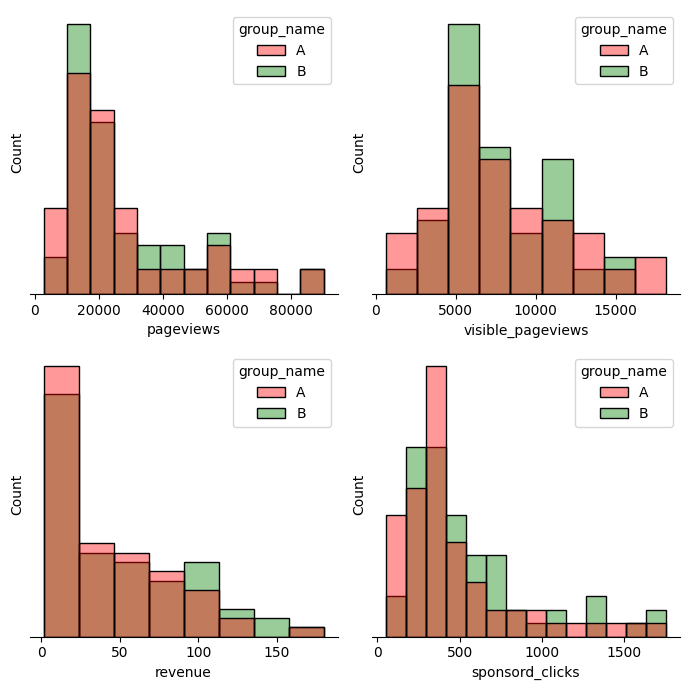

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
sns.despine(left=True)

sns.histplot(data = df,
             x='pageviews',
             hue='group_name',
             palette = ['r', 'g'],
             alpha=0.4,
             kde=False,
             ax=axes[0, 0])

sns.histplot(data = df,
              x='visible_pageviews',
              hue='group_name',
              palette = ['r', 'g'],
              alpha=0.4,
              kde=False,
              ax=axes[0, 1])

sns.histplot(data = df,
              x='revenue',
              hue='group_name',
              palette = ['r', 'g'],
              alpha=0.4,
              kde=False,
              ax=axes[1, 0])

sns.histplot(data = df,
              x='sponsord_clicks',
              hue='group_name',
              palette = ['r', 'g'],
              alpha=0.4,
              kde=False,
              ax=axes[1, 1])

plt.setp(axes, yticks=[])
plt.tight_layout()


Как видно из графиков, распределения всех характеристик не похожи на нормальное. В целом распределения групп схоже, имеются диапазаоны, где показатели группы А превалируют над показателями группы B, и есть диапазоны с обратной картинкой. По графикам нельзя однозначно сказать о наличии положительного эффекта от эксперимента.

Посмотрим, есть ли выбросы в данных на примере нескольких столбцов:

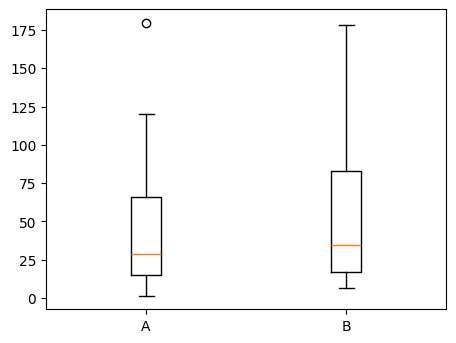

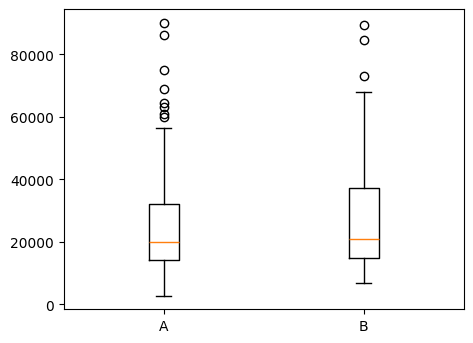

In [8]:
data1 = df[df['group_name']=='A']['revenue']
data2 = df[df['group_name']=='B']['revenue']
data3 = df[df['group_name']=='A']['pageviews']
data4 = df[df['group_name']=='B']['pageviews']
data_rev = [data1, data2]
data_view = [data3, data4]

fig = plt.figure(figsize =(4, 3))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data_rev)
ax.set_xticklabels(['A', 'B'])
plt.show()

fig = plt.figure(figsize =(4, 3))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data_view)
ax.set_xticklabels(['A', 'B'])
plt.show()

В данных имеется незначительное количество аномальных значений.  
Для очистки выбросов используем правило трех сигм, и проанализируем, сколько данных срезается.

In [9]:
#сохраним размер первоначального датасета
prev_df = len(df)

In [10]:
#избавимся от выбросов
for i in df[['visible_pageviews', 'revenue', 'sponsord_clicks', 'organic_clicks', 'sessions']]:
  df = df[~((df[i] < df[i].mean() - 3*df[i].std())
        | (df[i] > df[i].mean() + 3*df[i].std()))]

In [11]:
percent_removed = ((prev_df - len(df)) / prev_df) * 100
print("Процент удаленных данных: {:.2f}%".format(percent_removed))

Процент удаленных данных: 4.76%


Процент удаленных данных составил менее 5%, что находится в допускаемых пределах.

##6. Анализ полученных данных##

Проверим данные, которые участвуют в проверке гипотез на нормальность с помощью критерия Шапиро-Уилка.

In [12]:
alpha = 0.05
for i in df[['visible_pageviews', 'revenue', 'sponsord_clicks', 'organic_clicks', 'sessions']]:
  if float(shapiro(i)[1]) > alpha:
    print(f'данные в {i} распределены нормально')
  else:
    print(f'данные в {i} распределены не нормально')

данные в visible_pageviews распределены не нормально
данные в revenue распределены не нормально
данные в sponsord_clicks распределены не нормально
данные в organic_clicks распределены не нормально
данные в sessions распределены не нормально


Для проведения A/B-тестирования не обязательно, чтобы данные были строго нормально распределены. Важно, чтобы условия применения выбранного статистического метода были выполнены. Также, в соответствии с центральной предельной теоремой, при больших объемах выборок, распределение средних значений близко к нормальному. В нашем проекте, в целях повторения статистических методов и исключения сомнений, проведем проверку гипотез с помощью параметрических и непараметрических тестов.  

Так как цель нашего тестирования зафиксировать увеличение метрик RPM, RPS и CTR, то сперва рассчитаем их, а затем разделим наши данные по группам:

In [13]:
df['RPM'] = round(df['revenue']/df['visible_pageviews']*1000, 2)
df['RPS'] = round(df['revenue']/df['sessions']*1000, 2)
df['CTR_paid'] = round(df['sponsord_clicks']/df['visible_pageviews']*100, 2)
df['CTR_organic'] = round(df['organic_clicks']/df['visible_pageviews']*100, 2)

group_A = df[df['group_name']=='A']
group_B = df[df['group_name']=='B']

**Проверим гипотезу для CTR.**

In [14]:
ctr_paid_A = round(group_A['CTR_paid'].mean(), 2)
ctr_paid_B = round(group_B['CTR_paid'].mean(), 2)
ctr_organic_A = round(group_A['CTR_organic'].mean(), 2)
ctr_organic_B = round(group_B['CTR_organic'].mean(), 2)

print(f"""средний CTR_paid для группы A = {ctr_paid_A} %,
средний CTR_paid для группы B = {ctr_paid_B} %,
средний CTR_organic для группы A = {ctr_organic_A} %,
средний CTR_organic для группы B = {ctr_organic_B} %.
""")

средний CTR_paid для группы A = 6.15 %,
средний CTR_paid для группы B = 7.06 %,
средний CTR_organic для группы A = 19.88 %,
средний CTR_organic для группы B = 10.27 %.



Ситуация сложилась следующим образом: среднее CTR по рекламным объявлениям в группе B стало больше, а вот среднее CTR по органическим объявлениям в группе B стало меньше. Значит есть какой-то эффект от изменения расположения ленты с рекламными и органическими объявлениями. Осталось проверить статистическую значимость этого изменения. Используем тесты на равенство средних: сперва параметрический критерий Стьюдента, а затем непараметрический H-критерий Краскела-Уоллиса.  
Напомним, что:  

Н0: средние CTR_paid и CTR_organic не изменятся, μ1 = μ2.

Н1: Для CTR_paid правосторонняя, так как планируем увеличение переходов по рекламным объявлениям (μ1 < μ2), для CTR_organic левосторонняя, так как  с учетом полученных данных, в результате изменений, количество переходов по органическим объявлениям уменьшилось (μ1 > μ2).

Уровень значимости равен 0.05

In [15]:
#параметрический тест Стьюдента
print(ttest_ind(group_B['CTR_paid'], group_A['CTR_paid'], alternative='greater'))
ttest_ind(group_B['CTR_organic'], group_A['CTR_organic'], alternative='less')

TtestResult(statistic=1.7226475180981953, pvalue=0.04378603414438458, df=118.0)


TtestResult(statistic=-14.953969042172902, pvalue=2.60657644920094e-29, df=118.0)

In [16]:
#непараметрический тест Краскела-Уоллиса
print(kruskal(group_B['CTR_paid'], group_A['CTR_paid']))
kruskal(group_B['CTR_organic'], group_A['CTR_organic'])

KruskalResult(statistic=4.529821871730035, pvalue=0.033309084618513576)


KruskalResult(statistic=81.3100481404186, pvalue=1.9294306375357087e-19)

Во всех проведенных тестах p-value меньше уровня значимости, поэтому нам следует отвергнуть нулевые гипотезы, а это значит, что изменения в поведении пользователей, в результате корректировки расположения рекламных и органических элементов, статистически значимы. Хотя, касаемо CTR_paid, p-value и alpha достаточно близки, и при уровне значимости равном 0.01, мы бы уже не отвергли нулевую гипотезу. Поэтому, важно продолжить отслеживать данные результаты, так как изменения могут носить краткосрочный эффект, и по итогу мы можем получить, что пользователи перестанут кликать по рекламе, а по органическим объявлениям переходы уже сократились. В результате чего, возможно, пользователи могут реже использовать сайт или вовсе перестать пользоваться, найдя замену.

**Проверим гипотезу для RPM и RPS.**

In [17]:
rpm_A = round(group_A['RPM'].mean(), 2)
rpm_B = round(group_B['RPM'].mean(), 2)
rps_A = round(group_A['RPS'].mean(), 2)
rps_B = round(group_B['RPS'].mean(), 2)

print(f"""средний RPM для группы A = {rpm_A} $,
средний RPM для группы B = {rpm_B} $,
средний RPS для группы A = {rps_A} $,
средний RPS для группы B = {rps_B} $.
""")

средний RPM для группы A = 6.72 $,
средний RPM для группы B = 8.14 $,
средний RPS для группы A = 5.04 $,
средний RPS для группы B = 5.65 $.



Заметно, что метрики в группе B стали больше, но нужно проверить значимо ли статистически это изменение. Также, как и для проверки предыдущей гипотезы, используем тесты на равенство средних: сперва параметрический критерий Стьюдента, а затем непараметрический H-критерий Краскела-Уоллиса.  
Напомним, что:  

Н0: средние RPM и RPS не изменятся, μ1 = μ2.

Н1: Правосторонняя, так как планируем положительное изменение (увеличение метрик), μ2 > μ1.

Уровень значимости равен 0.05

In [18]:
#параметрический тест Стьюдента
print(ttest_ind(group_B['RPM'], group_A['RPM'], alternative='greater'))
ttest_ind(group_B['RPS'], group_A['RPS'], alternative='greater')


TtestResult(statistic=1.2087833708444022, pvalue=0.11458134838805771, df=118.0)


TtestResult(statistic=0.6359021861437323, pvalue=0.263035799528644, df=118.0)

In [19]:
#непараметрический тест Краскела-Уоллиса
print(kruskal(group_B['RPM'], group_A['RPM']))
kruskal(group_B['RPS'], group_A['RPS'])

KruskalResult(statistic=0.978870256805564, pvalue=0.32247788079491874)


KruskalResult(statistic=0.08333651654632226, pvalue=0.772825773132958)

Во всех проведенных тестах p-value больше уровня значимости, поэтому мы не можем отвергнуть нулевую гипотезу, а это значит, что изменения в метриках RPM и RPS не значимы статистически. По результатам двух тестов можно сделать вывод, что количество кликов по рекламным элементам выросло, а вот доход от этого значимо не прибавился. Поэтому необходимо разобраться, возможно, пересмотреть ценовую политику с рекламодателями, а может существующая реклама не интересна аудитории нашего сайта, и нужно размещать рекламный контент, интересный нашим клиентам.

##7. Презентация результатов##

[Ссылка на презентацию](https://disk.yandex.ru/i/mWMJlVGWTnb8Jg)